# Import Modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, GlobalMaxPooling2D, Dense
# To show images
from PIL import Image
print("status ok")

2024-01-27 17:32:06.746089: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-27 17:32:06.767974: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 17:32:06.877112: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 17:32:06.877150: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 17:32:06.877811: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

status ok



# Create Functions

#### Creates data frame

In [2]:
# Collect all data into one dataframe
def create_df(dataset, sample_size):
    image_paths, labels = [], []

    for dirpath, dirnames, filenames in os.walk(dataset):
        for i, filename in enumerate(filenames):
            if i >= sample_size:
                break
            
            image = os.path.join(dirpath, filename)
            image_paths.append(image)
            if dirpath[-3:] == 'all':
                labels.append('all')
            else:
                labels.append('hem')

    df = pd.DataFrame({'Image Path': image_paths, 
                       'Label': labels})
    
    return df

train_dir = "C-NMC_Leukemia/training_data"
df = create_df(train_dir, 500)

train_df, remaining_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=31, stratify=df['Label'])
valid_df, test_df = train_test_split(remaining_df, train_size=0.5, shuffle=True, random_state=31, stratify=remaining_df['Label'])

print("Number of training samples: %d" % len(train_df.index))
print("Number of test samples: %d" % len(test_df.index))  
print("Number of validation samples: %d" % len(valid_df.index))

Number of training samples: 2100
Number of test samples: 450
Number of validation samples: 450


#### Display Model Performance

In [3]:
def show_history_plot(history):

    training_accuracy = history['accuracy']
    epochs = range(1, len(training_accuracy) + 1)

    # Creating subplots for accuracy and loss
    plt.figure(figsize=(15, 5))

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.plot(epochs, history['accuracy'], 'b', label='Training accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], 'c', label='Validation accuracy', marker='o')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(epochs, history['loss'], 'b', label='Training loss', marker='o')
    plt.plot(epochs, history['val_loss'], 'c', label='Validation loss', marker='o')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Improve layout and displaying the plot
    plt.tight_layout()
    plt.show()

#### Confusion Matrix

In [4]:
def show_conf_matrix(model):
    test_gen.reset()  # Reset the generator to be sure it's at the start of the dataset
    y_pred = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size+1, verbose=0)

    label_dict = test_gen.class_indices
    classes = list(label_dict.keys())

    # Convert predictions to labels
    pred_labels = np.argmax(y_pred, axis=1)  
    y_true = test_gen.classes  
    
    # Generate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_true, pred_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])

    # Plot the confusion matrix 
    cmap = plt.cm.Blues
    cm_display.plot(cmap=cmap, colorbar=False)  
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.figure(figsize=(7, 7)) 
    plt.show()

#### Evaluation Matrix

In [5]:
def evaluation_matrix(model):
    test_steps = len(test_df) // batch_size
    train_score = model.evaluate(train_gen, steps= test_steps, verbose= 0)
    valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 0)
    test_score = model.evaluate(test_gen, steps= test_steps, verbose= 0)

    header = "{:<12} {:<10} {:<10}".format("", "Loss", "Accuracy") 
    separator = '-' * len(header)
    train_row = "{:<12} {:<10.5f} {:<10.5f}".format("Train", train_score[0], train_score[1])  # Formats the float to five decimal places
    valid_row = "{:<12} {:<10.5f} {:<10.5f}".format("Validation", valid_score[0], valid_score[1])
    test_row = "{:<12} {:<10.5f} {:<10.5f}".format("Test", test_score[0], test_score[1])

    table = '\n'.join([header, separator, train_row, valid_row, test_row])
    print(table)

#### Show Images

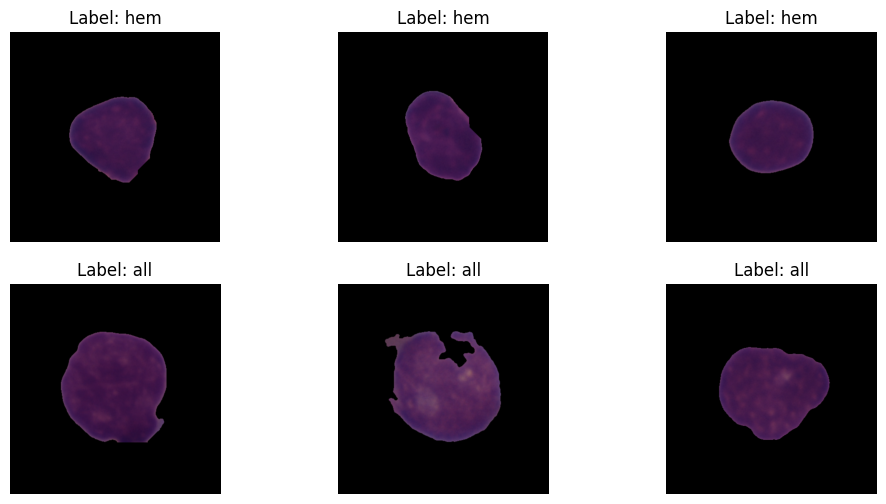

In [6]:
hem_img = train_df[train_df['Label'] == 'hem'].sample(3)
all_img = train_df[train_df['Label'] == 'all'].sample(3)
sampled_df = pd.concat([hem_img, all_img])

# Create a figure with subplots to show the images in
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, row in enumerate(sampled_df.iterrows()):
    img = mpimg.imread(row[1]['Image Path'])
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.axis('off')    
    if row[1]['Label'] == 'hem':
        ax.set_title(f"Label: hem")
    else:
        ax.set_title(f"Label: all")

plt.show()

#### Initializing Image Data Generators 

In [7]:
batch_size = 40

train_data_generator = ImageDataGenerator(horizontal_flip=True)
valid_data_generator = ImageDataGenerator()

train_gen = train_data_generator.flow_from_dataframe( train_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = valid_data_generator.flow_from_dataframe( valid_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = valid_data_generator.flow_from_dataframe( test_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

train_steps = test_gen.n // test_gen.batch_size + 1
validation_steps = valid_gen.n // valid_gen.batch_size 

Found 2100 validated image filenames belonging to 2 classes.


Found 450 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.


## Hybrid Model

In [8]:
#Load pretrained models from the h5 folder
from tensorflow.keras.models import load_model

xception_model=load_model("./LeukemiaResearch/h5files/LeukXception.h5")
inception_model=load_model("./LeukemiaResearch/h5files/LeukInception.h5")

2024-01-27 17:32:11.369803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-27 17:32:11.479854: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate

# Assume you have three pre-trained models: model1, model2, and model3
model1 = xception_model
model2 = inception_model

# input_shape=(224,224,3)

# Define input layer (assuming the input shapes are the same for all models)
input_layer = Input(shape=(224,224,3))

# Get the output tensors of each model
output1 = model1(input_layer)
output2 = model2(input_layer)

# Apply Dense layers to each output
x1 = Dense(512, activation = "relu")(output1)
x2 = Dense(512, activation = "relu")(output2)

# Merge the outputs
merged = concatenate([x1,x2])
merged = Dense(256, activation='relu')(merged)   
d1 = Dropout(0.2)(merged)
h2 = Dense(128, activation = "relu")(d1)
d2 = Dropout(0.2)(h2)

# Create the final output layer
output = Dense(2, activation='softmax')(d2)

# Create the ensemble model
ensemble_model = Model(inputs=input_layer, outputs=output)


#### Train Model

In [10]:
from tensorflow.keras.metrics import Recall, Precision
ensemble_model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='binary_crossentropy',  # Use 'binary_crossentropy' for binary classification
    metrics=['accuracy', Recall(name='recall'), Precision(name='precision')]
)

ensemble_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Xception (Functional)       (None, 2)                    1769066   ['input_1[0][0]']             
                                                          6                                       
                                                                                                  
 InceptionV3 (Functional)    (None, 2)                    8976802   ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 512)                  1536      ['Xception[0][0]']        

Total params: 26966094 (102.87 MB)
Trainable params: 303238 (1.16 MB)
Non-trainable params: 26662856 (101.71 MB)
__________________________________________________________________________________________________


In [11]:
epochs = 25

history_ensemble = ensemble_model.fit(
    train_gen, 
    steps_per_epoch=train_steps,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/25
12/12 [==============================] - 47s 4s/step - loss: 0.6639 - accuracy: 0.6583 - recall: 0.6583 - precision: 0.6583 - val_loss: 0.5994 - val_accuracy: 0.7591 - val_recall: 0.7591 - val_precision: 0.7591
Epoch 2/25
12/12 [==============================] - 41s 4s/step - loss: 0.6159 - accuracy: 0.6979 - recall: 0.6979 - precision: 0.6979 - val_loss: 0.5539 - val_accuracy: 0.7386 - val_recall: 0.7386 - val_precision: 0.7386
Epoch 3/25
12/12 [==============================] - 40s 3s/step - loss: 0.5910 - accuracy: 0.6917 - recall: 0.6917 - precision: 0.6917 - val_loss: 0.5423 - val_accuracy: 0.7386 - val_recall: 0.7386 - val_precision: 0.7386
Epoch 4/25
12/12 [==============================] - 41s 4s/step - loss: 0.5959 - accuracy: 0.7188 - recall: 0.7188 - precision: 0.7188 - val_loss: 0.5358 - val_accuracy: 0.7432 - val_recall: 0.7432 - val_precision: 0.7432
Epoch 5/25
12/12 [==============================] - 40s 3s/step - loss: 0.5889 - accuracy: 0.6979 - recall: 0.69

#### Evaluate Model

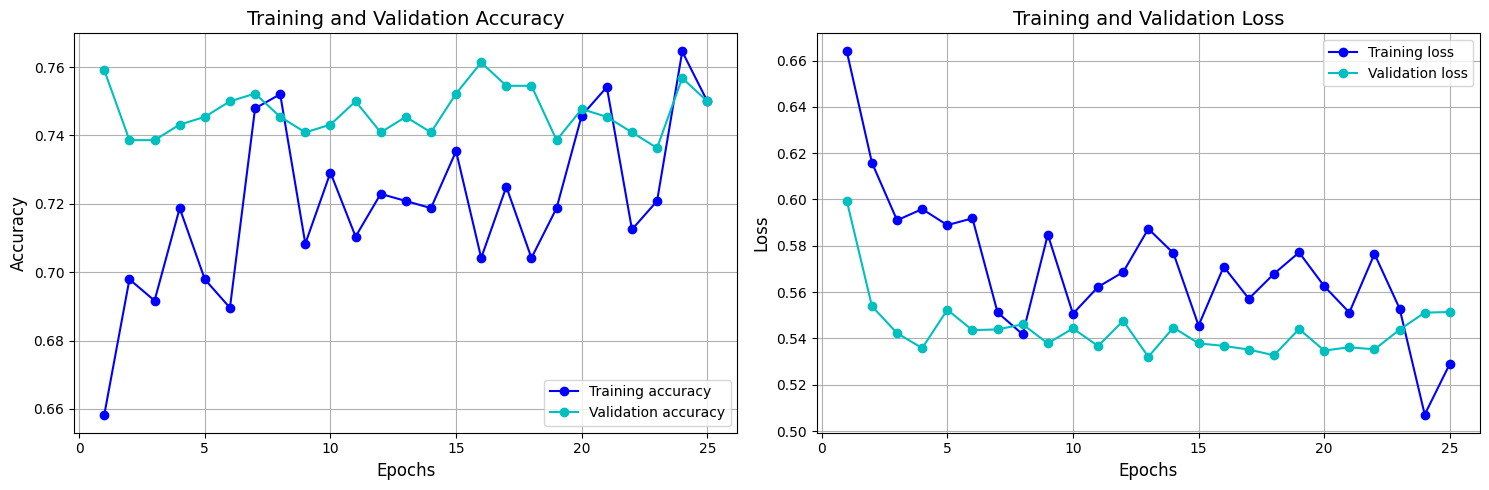

In [12]:
show_history_plot(history_ensemble.history)


In [13]:
evaluation_matrix(ensemble_model)

             Loss       Accuracy  
----------------------------------
Train        0.54585    0.75909   
Validation   0.54856    0.75000   
Test         0.52912    0.75682   


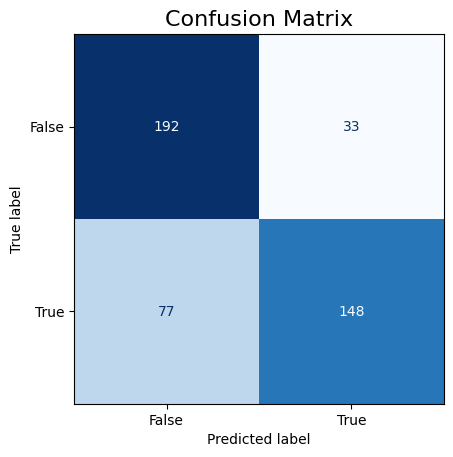

<Figure size 700x700 with 0 Axes>

In [14]:
show_conf_matrix(ensemble_model)

In [16]:
ensemble_model.save('LeukHybrid25.h5')

ValueError: Unable to create dataset (name already exists)